# Volatility smile

## Recall BSM formula

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import scipy.optimize as so

In [2]:
'''============
Gbm class inherited from sde_1d
Usage:
    gbm1 = Gbm(init_state = 100., drift_ratio=.05, vol_ratio=.2)
============='''

class Gbm:
    def __init__(self,
                 init_state = 100.,
                 drift_ratio = .0475,
                 vol_ratio = .2
                ):
        self.init_state = init_state
        self.drift_ratio = drift_ratio
        self.vol_ratio = vol_ratio
        
        

In [3]:
'''=========
option class init
Usage:
    option1 = EuropeanOption(otype = 1, strike = 100., maturity = 1/12)
=========='''
class EuropeanOption:
    def __init__(self,
                otype = 1, # 1: 'call'
                        # -1: 'put'
                strike = 110.,
                maturity = 1.
                ):
        self.otype = otype
        self.strike = strike
        self.maturity = maturity
        
    def payoff(self, s): #s: excercise price
        otype = self.otype
        k = self.strike
        maturity = self.maturity
        return np.max([0, (s - k)*otype])
        

In [4]:
'''========
Black-Scholes-Merton formula. 
=========='''

def bsm_price(self, european_option):
    s0 = self.init_state
    sigma = self.vol_ratio
    r = self.drift_ratio
    
    otype = european_option.otype
    k = european_option.strike
    maturity = european_option.maturity
    
    d1 = (np.log(s0 / k) + (r + 0.5 * sigma ** 2) 
          * maturity) / (sigma * np.sqrt(maturity))
    d2 = d1 - sigma * np.sqrt(maturity)
    
    return otype * s0 * ss.norm.cdf(otype * d1) - otype * np.exp(-r * maturity) * k * ss.norm.cdf(otype * d2)

Gbm.bsm_price = bsm_price

In [5]:
'''===============
Test bsm_price
================='''
gbm1 = Gbm()
option1 = EuropeanOption()
print('>>>>>>>call value is ' + str(gbm1.bsm_price(option1)))
option2 = EuropeanOption(otype=-1)
print('>>>>>>>>put value is ' + str(gbm1.bsm_price(option2)))


>>>>>>>call value is 5.943273183452838
>>>>>>>>put value is 10.84042522804176


## Implied volatility

In the market, usually volatility (vol = 0.2 in the above) is not available, but market price (call = 5.94) for the option is available. One wants find a volatility such that associated BSM formula is equal to (fit) the market price. 

In [6]:
'''==========
define a method to seek for an implied volatility
============'''

def implied_volatility(spot_price, otype, maturity, strike, interest_rate, market_option_price):
    option = EuropeanOption(otype, strike, maturity)
    init_vol = .1 #initial guess
    gbm = Gbm(spot_price, interest_rate, init_vol)
    
    def error_function(vol):
        gbm.vol_ratio = vol
        return np.abs(market_option_price - gbm.bsm_price(option))
    
    return so.fmin(error_function, 0.1, disp = False)[0]

In [7]:
'''============
test the implied_vol by reversing bsm_formula example in the above
=============='''
print('>>>>>>>>implied volatility is')
implied_volatility(spot_price=100, otype=1, maturity=1, strike=110, interest_rate=.0475, market_option_price=5.94)

>>>>>>>>implied volatility is


0.19992187500000036

## Volatility smile

Next, we shall compute volatility smiles to multiple market option prices. For instance, we can fix the maturity, and compute volatilities for different strikes. If we plot a strike versus vol figure , it usually gives volatility smile.

In [29]:
'''======
Read data
========='''
#Read four-column data
#columns are otype, maturity, strike, option_price
np_option_data1 = np.loadtxt('optiondata2.dat', comments='#', delimiter=',')

print('>>>>>>otype, maturity, strike, option_price')
print(np_option_data1)

>>>>>>otype, maturity, strike, option_price
[[  1.           0.16666667  97.           5.32705461]
 [  1.           0.16666667  99.           3.86224255]
 [  1.           0.16666667 101.           2.7204371 ]
 [  1.           0.16666667 103.           2.1202793 ]
 [  1.           0.41666667  97.           7.23756307]
 [  1.           0.41666667  99.           5.95053461]
 [  1.           0.41666667 101.           5.2640122 ]
 [  1.           0.41666667 103.           4.97493422]]


In [15]:
#below are market data 
spot_price = 100
interest_rate = .05

#expand one column for vol
num_row = np_option_data1.shape[0]
np_option_data2 = np.append(np_option_data1, np.zeros([num_row,1]), axis = 1)

In [30]:
#compute implied vol
for i in range(num_row):
    otype = np_option_data1[i, 0]
    maturity = np_option_data1[i,1]
    strike = np_option_data1[i,2]
    market_option_price = np_option_data1[i,3]
    
    np_option_data2[i, 4] = implied_volatility(spot_price, otype, maturity, strike, interest_rate, market_option_price)
    
print('>>>>>>otype, maturity, strike, option_price, implied vol')
print(np_option_data2)

>>>>>>otype, maturity, strike, option_price, implied vol
[[  1.           0.16666667  97.           5.44237971   0.19125   ]
 [  1.           0.16666667  99.           3.77163898   0.17724609]
 [  1.           0.16666667 101.           3.15002236   0.17183594]
 [  1.           0.16666667 103.           2.36850195   0.18681641]
 [  1.           0.41666667  97.           7.72507731   0.170625  ]
 [  1.           0.41666667  99.           5.84588003   0.16804688]
 [  1.           0.41666667 101.           5.55533383   0.18373047]
 [  1.           0.41666667 103.           4.4444931    0.20901367]]


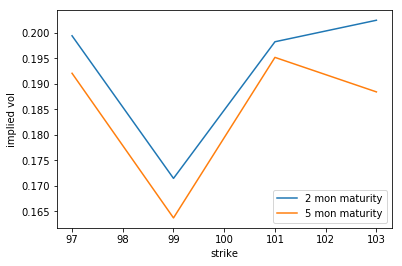

In [28]:
filter1 = np_option_data2[np_option_data2[:,1] == 2/12]
plt.plot(filter1[:,2], filter1[:,4], label = '2 mon maturity')
filter2 = np_option_data2[np_option_data2[:,1] == 5/12]
plt.plot(filter2[:,2], filter2[:,4], label = '5 mon maturity')
plt.ylabel('implied vol')
plt.xlabel('strike')
plt.legend()
plt.show()